##  Basic examples: getting started

In the `data` folder is provided a continuum subtracted image (I haven't removed the skylines) of the HD163296 jet taken in 2017 with the [MUSE](http://muse-vlt.eu/science/) instrument on the Very Large Telescope (VLT) operated by the European Southern Observatory (ESO) under Program ID 099.C-0214(A). The PV-slice was generated using [`pvextractor`](https://github.com/keflavich/pvextractor) (which is a super useful tool!) and spans a range of $6000-6800\dot{\rm A}$. We will look at the $\rm{[OI]}\lambda6300$ emission and the $\rm H\alpha$ emission.

In [105]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import telassar

In [2]:
home = os.path.expanduser("~")
working = os.path.join(home, "telassar")
os.chdir(working)
from telassar import PVSlice

In [3]:
file = os.path.join(working, "data/hd163296_pvslice.fits")
pvdiag = PVSlice(file)

pvdiag.info()

[INFO] PVSlice (/home/voekreb/telassar/data/hd163296_pvslice.fits)
[INFO] Data shape: (376 x 641) (arcsec, Angstrom)
[INFO] Spatial Offset: min: -37.6" max: 37.4" step: 0.200"
[INFO] Spectral extent: min 6000.00 Angstrom max: 6800.00 Angstrom step: 1.250 Angstrom


<IPython.core.display.Javascript object>


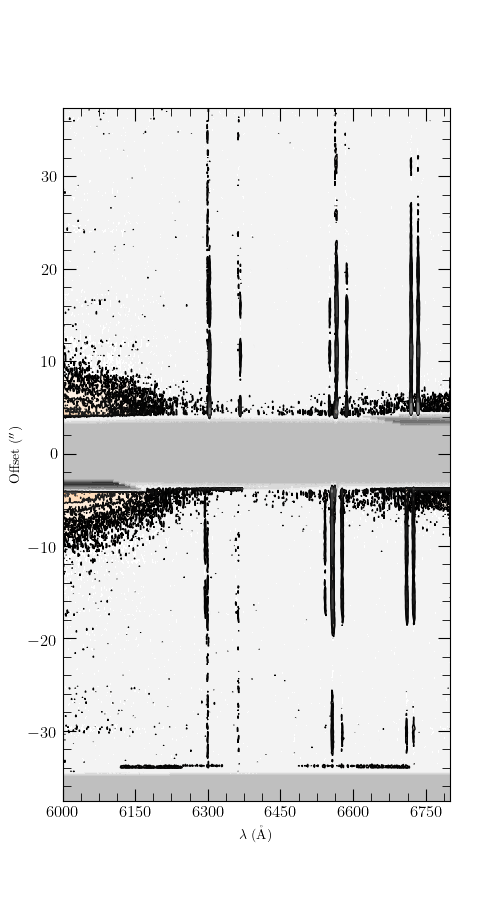

In [5]:
%matplotlib notebook

# make a simple plot
pvdiag.plot_contours()

Some customization of the plot can be done. For example, we can trim the image to get a window around the $\rm{[OI]}\lambda6300$ emission line with `spectral_window()`, then call the `radial_velocity()` method to get a rough estimate of the velocity ranges and format x-axis accordingly. By default, `spectral_window()` assumes pixel units, so if we don't want that we can specify the units.

Additionally, if a systemic velocity is known for an object, you can specify the `vcorr` parameter in the `radial_velocity()` function. For this object, we will correct for the systemic motion of the star with $v_{\rm sys}$=5. km/s, with respect to the LSR (Qi et al., 2011, ApJ, 740, 84, [doi:10.1088/0004-637X/740/2/84](https://ui.adsabs.harvard.edu/link_gateway/2011ApJ...740...84Q/doi:10.1088/0004-637X/740/2/84)).

In [14]:
# OI6300
oi6300 = pvdiag.spectral_window(vmin=6288, vmax=6312, unit='angstrom')

lbda1, lbda2 = oi6300.velwave.get_range()
vsys = 5.8

oi_vrad = oi6300.radial_velocity(ref='OI6300', lbdas=[lbda1, lbda2], vcorr=vsys)

Now, let's inspect it. With the `plot_contours()` method we can specify several parameters:

In [7]:
help(oi6300.plot_contours)

Help on method plot_contours in module telassar.pvslice:

plot_contours(figure=None, place=None, sigma=None, mask=None, levels1=None, levels2=None, cmaps=None, fig_kws=None, plt_kws=None, emline=None) method of telassar.pvslice.PVSlice instance
    Generate a contour plot of the data. Useful for jet visualization!
    
    Parameters
    -----------
    figure : None or `matplotlib.Figure` instance
        if you have a figure instance you want to send this to, specify it
    sigma : None or float
        the basis for generating levels. a 3sigma value indicates detection
        of a source, we abbreviate it here to just sigma
    place : int
        if you have multiple subplot axes, you can send the image to one
    mask : `np.ma.masked_array`
        if you want to specify a mask to send when computing the background
        levels, do it here
    levels1 : None or `np.ndarray` or list
        the contour levels for the jets
    levels2 : None or `np.ndarray` or list
        the co

So there's an attempt here at making a fairly easily customizable plot. Anything not specified by the user will be estimated by the plotter. The standard contour levels honestly aren't the best, and I haven't figured out a good way to handle them. But, we can define our own, so let's pass a few keywords and try them out.

<IPython.core.display.Javascript object>


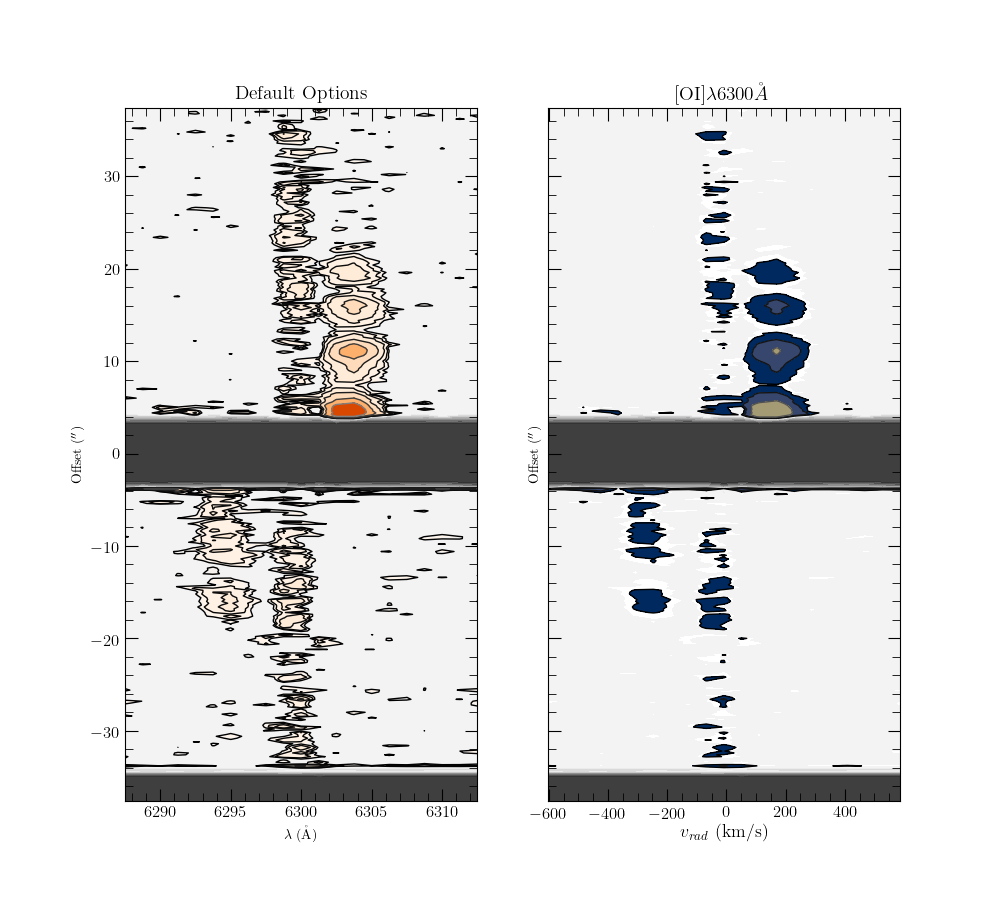

Text(0.5, 0, '$v_{rad}$ (km/s)')

In [15]:
%matplotlib notebook
from telassar.plotter import get_background_rms

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 9))

# Just use default options
oi6300.plot_contours(figure=fig, place=0, emline="Default Options") 

# customize it a bit
# calculate a background rms at a desired sigma value
nsig = get_background_rms(oi6300.data, sigma=5.)

# set increasing levels in sqrt(2) increments
levels = [nsig * np.sqrt(2)**i for i in range(2, 14, 3)]
# print(levels)

# we can also define our own extent, using our radial velocity array
y1, y2 = oi6300.position.get_range()
x1, x2 = oi_vrad
extent = {'extent' : [x1, x2, y1, y2]}
oi6300.plot_contours(figure=fig, 
                     place=1,
                     levels1=levels,
                     cmaps=['gist_gray', 'cividis', 'gray'],
                     plt_kws=extent,
                     emline="OI6300",
)

# just fix the x-axis label
axes[1].set_xlabel(r"$v_{rad}$ (km/s)", fontsize=13)

## Skyline emissions

As can be seen from the above plots, there is an annoying skyline emission almost right on the $6300\dot{A}$ line. With `telassar` we can register a user-specified file containing the emission regions we identify usinng the `.register_skylines()` function. Once we register this file, we can remove the skylines from the image with `.skymask()` with either spline interpolation or a simple 1D interpolation. Alternatively, if we do not with to create a file (overkill for a single line) we can specify a wavelength range. 

In some cases, the red- or blue-shifted emissions may be quite close to the skyline, so to better tailor the function we can specify a spatial range over which to perform the removal. In this case the removal process can be iterative.

We demonstrate both methods below. We include a `badlines.dat` file in the `data` directory as a template. An in-place operation can be specified, but it is `False` by default.

In [16]:
# make a copy to show both methods
oi6300_copy = oi6300.copy()
oi6300_copy2 = oi6300.copy()

# Method 1
# register the file
oi6300_copy.register_skylines("data/badlines.dat")

# this is saved to a `skylines` dict
print(oi6300_copy.skylines)

# mask the lines
oi6300_copy.skymask(verbose=True)

# now fix it
oi_skyfixed = oi6300_copy.skysub(progress=True, spline=True)

[INFO] Masking OI6300 line...
[INFO] Interpolating masked regions...
100%|██████████| 376/376 [00:00<00:00, 2681.13it/s]

{'OI6300': [6297.5, 6301.25]}


In [24]:
oi6300_copy2 = oi6300.copy()

oi6300_copy2.skymask(wave=[6298, 6301], arcs=[0, 37], verbose=True)
oi_skyfixed2 = oi6300_copy2.skysub(progress=True)

[INFO] Interpolating masked regions...
100%|██████████| 376/376 [00:00<00:00, 2139.05it/s]


<IPython.core.display.Javascript object>


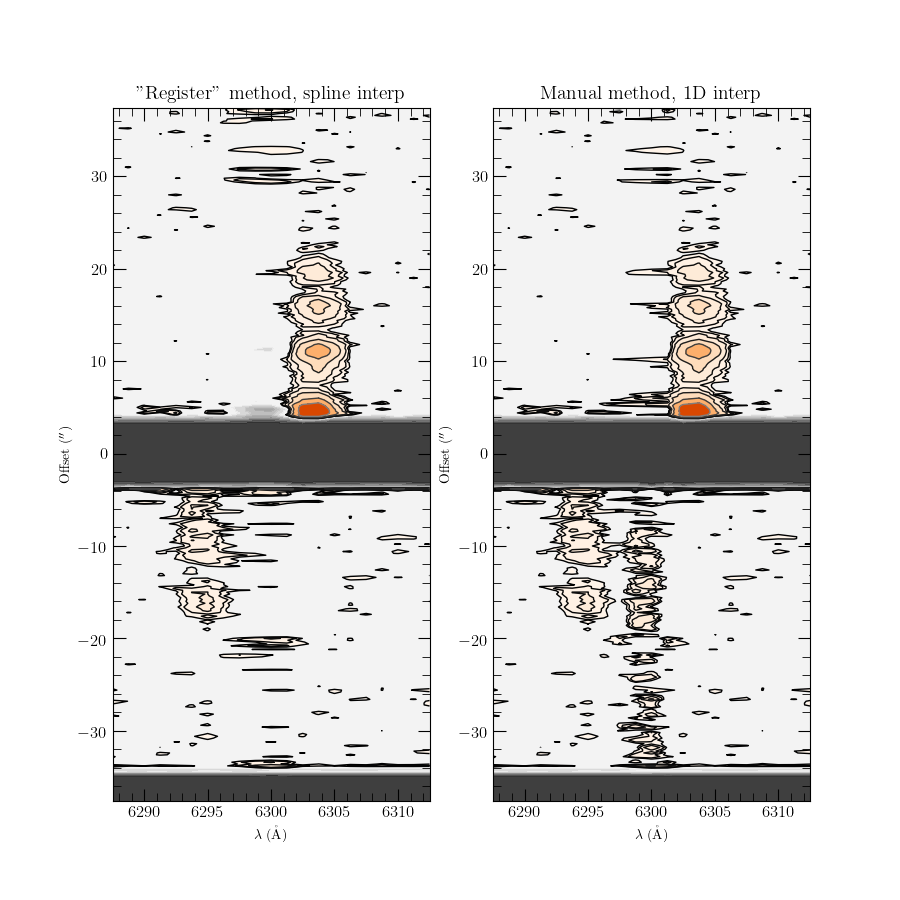

In [25]:
%matplotlib notebook


fig, axes = plt.subplots(ncols=2, figsize=(9, 9))
oi_skyfixed.plot_contours(figure=fig, place=0, emline='"Register" method, spline interp')
oi_skyfixed2.plot_contours(figure=fig, place=1, emline='Manual method, 1D interp')

In the next notebook, we will show some basic fitting routines.